数据观察、预处理

In [188]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
data = pd.read_csv('data/OnlineShopping_order_report.csv')
data.head() # 退款金额应该就是客户退货后，返还给客户的退款金额

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
0,1,178.8,0.0,上海,2020-02-21 00:00:00,NaN,0.0
1,2,21.0,21.0,内蒙古自治区,2020-02-20 23:59:54,2020-02-21 00:00:02,0.0
2,3,37.0,0.0,安徽省,2020-02-20 23:59:35,NaN,0.0
3,4,157.0,157.0,湖南省,2020-02-20 23:58:34,2020-02-20 23:58:44,0.0
4,5,64.8,0.0,江苏省,2020-02-20 23:57:04,2020-02-20 23:57:11,64.8


In [189]:
data.info()  # 数据集情况 28010 条，7个字段

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28010 entries, 0 to 28009
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   订单编号      28010 non-null  int64  
 1   总金额       28010 non-null  float64
 2   买家实际支付金额  28010 non-null  float64
 3   收货地址      28010 non-null  object 
 4   订单创建时间    28010 non-null  object 
 5   订单付款时间    24087 non-null  object 
 6   退款金额      28010 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.5+ MB


In [190]:
# 处理列名有空格
data.columns = data.columns.str.strip() 
data.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址', '订单创建时间', '订单付款时间', '退款金额'], dtype='object')

In [191]:
data[data.duplicated(keep='first')].count()  # 没有完全重复的数据

订单编号        0
总金额         0
买家实际支付金额    0
收货地址        0
订单创建时间      0
订单付款时间      0
退款金额        0
dtype: int64

In [192]:
data.isnull().sum()   # 付款时间存在空值，表示订单未付款

订单编号           0
总金额            0
买家实际支付金额       0
收货地址           0
订单创建时间         0
订单付款时间      3923
退款金额           0
dtype: int64

In [193]:
data['收货地址'] = data['收货地址'].str.replace(
    r'(自治区|维吾尔自治区|回族自治区|壮族自治区|省)$',  # $表示匹配结尾
    '', 
    regex=True
)
data['收货地址'].unique()

array(['上海', '内蒙古', '安徽', '湖南', '江苏', '浙江', '天津', '北京', '四川', '贵州', '辽宁',
       '河南', '广西', '广东', '福建', '海南', '江西', '甘肃', '河北', '黑龙江', '云南', '重庆',
       '山西', '吉林', '山东', '陕西', '湖北', '青海', '新疆', '宁夏', '西藏'], dtype=object)

In [194]:
data['收货地址'].value_counts()

收货地址
上海     3353
广东     2463
江苏     2126
浙江     2061
北京     2054
四川     2019
山东     1804
辽宁     1187
天津     1153
湖南     1099
河北     1083
重庆     1036
河南      966
云南      778
安徽      609
陕西      536
福建      489
山西      465
广西      436
江西      411
吉林      401
黑龙江     379
贵州      345
内蒙古     215
海南      178
甘肃      167
湖北       75
新疆       58
宁夏       42
青海       19
西藏        3
Name: count, dtype: int64

数据分析可视化

In [195]:
result = {}
result['总订单数'] = data['订单编号'].count()  # 统计所有订单的数量（含未付款订单）
result['已完成订单数'] = data['订单编号'][data['订单付款时间'].notnull()].count()  # 统计已付款订单数量（付款时间非空）
result['未付款订单数'] = data['订单编号'][data['订单付款时间'].isnull()].count()  # 统计未付款订单数量（付款时间为空）
result['退款订单数'] = data['订单编号'][data['退款金额'] > 0].count()  # 统计发生过退款的订单数量（退款金额>0）
result['总订单金额'] = data['总金额'][data['订单付款时间'].notnull()].sum()  # 计算已付款订单的原始总金额（未扣除退款）
result['总退款金额'] = data['退款金额'][data['订单付款时间'].notnull()].sum()  # 计算已付款订单的退款总额
result['总实际收入金额'] = data['买家实际支付金额'][data['订单付款时间'].notnull()].sum()
# result['总实际收入金额'] = result['总订单金额']- result['总退款金额']
# 计算转化率、退款率等
result['付款转化率'] = result['已完成订单数'] / result['总订单数']
result['退款率'] = result['退款订单数'] / result['已完成订单数']

result

{'总订单数': 28010,
 '已完成订单数': 24087,
 '未付款订单数': 3923,
 '退款订单数': 5646,
 '总订单金额': 2474823.0700000003,
 '总退款金额': 572335.9199999999,
 '总实际收入金额': 1902487.1500000001,
 '付款转化率': 0.8599428775437343,
 '退款率': 0.23440029891642794}

In [196]:
from pyecharts import options as opts  # 提供图表配置项的快捷方式，用于自定义图表样式、坐标轴、图例等。
# map绘制地理空间数据的热力图、区域分布图等。
# bar绘制柱状图
# line绘制折线图
from pyecharts.charts import Map, Bar, Line
from pyecharts.components import Table  # 生成表格的组件
from pyecharts.options import ComponentTitleOpts  # 为组件（如表格）设置标题样式。

In [197]:
from pyecharts.faker import Faker  # 虚拟数据生成工具，用于快速测试图表。
# Faker.choices()：生成随机分类数据。
# Faker.values()：生成随机数值。

In [198]:
headers = ['总订单数', '总订单金额', '已完成订单数', '总实际收入金额', '退款订单数', '总退款金额', '成交率', '退货率']
rows = [
    [
        result['总订单数'], 
        f"{result['总订单金额']/10000:.2f} 万", 
        result['已完成订单数'], 
        f"{result['总实际收入金额']/10000:.2f} 万",
        result['退款订单数'], 
        f"{result['总退款金额']/10000:.2f} 万", 
        f"{result['已完成订单数'] / result['总订单数']:.2%}" if result['总订单数'] > 0 else "0.00%",
        f"{result['退款订单数'] / result['已完成订单数']:.2%}" if result['已完成订单数'] > 0 else "0.00%",
    ]
]
table = (Table()
         .add(headers, rows)
         .set_global_opts(title_opts=ComponentTitleOpts(title='整体情况'))
         )
table.render("整体情况.html")  # 默认生成可交互的 HTML 文件
# 由于 pyecharts 生成的是 HTML 代码，这个方法可以在 Jupyter Notebook 里直接显示表格，而不是输出 HTML 文件。
table.render_notebook()

总订单数,总订单金额,已完成订单数,总实际收入金额,退款订单数,总退款金额,成交率,退货率
28010,247.48 万,24087,190.25 万,5646,57.23 万,85.99%,23.44%


In [199]:
# 统计每个 收货地址 对应的 订单编号 数量（即每个地区的订单量）

# data['订单付款时间'].notnull() 返回一个布尔Series，True 表示已付款
# 生成一个 DataFrameGroupBy 对象，后续可对每组进行聚合操作
# 对每个分组的 订单编号 列计数（统计每个地址的订单数）,{'订单编号': 'count'}：字典键为列名，值为聚合函数（这里是计数 count）
result2 = data[data['订单付款时间'].notnull()].groupby('收货地址').agg({'订单编号':'count'})
# print(result2)
result21 = result2.to_dict()['订单编号']
print(result21)

# items() 返回键值对，* 解包为元组列表，格式：[("北京", 150), ("上海", 200)]
# "china"：指定地图类型为中国地图（支持省份/城市级粒度）
c = (
    Map()
    .add("订单量", [*result21.items()], "china", is_map_symbol_show=False) # is_map_symbol_show=False：隐藏地图上的默认标记点。
    .set_series_opts(label_opts=opts.LabelOpts(is_show=True)) # 显示地图上的省市名称。
    .set_global_opts(
        title_opts=opts.TitleOpts(title='地区分布'),
        visualmap_opts=opts.VisualMapOpts(max_=2000),  # 添加颜色渐变视觉映射（热力图效果），颜色深浅代表数值大小  
    )
)
c.render("订单分布.html")
c.render_notebook()


{'上海': 3060, '云南': 667, '内蒙古': 176, '北京': 1853, '吉林': 336, '四川': 1752, '天津': 1031, '宁夏': 40, '安徽': 528, '山东': 1484, '山西': 395, '广东': 2022, '广西': 353, '新疆': 43, '江苏': 1845, '江西': 331, '河北': 885, '河南': 792, '浙江': 1822, '海南': 156, '湖北': 57, '湖南': 935, '甘肃': 132, '福建': 425, '西藏': 2, '贵州': 286, '辽宁': 1012, '重庆': 896, '陕西': 441, '青海': 18, '黑龙江': 312}


In [200]:
data['订单创建时间'] = pd.to_datetime(data['订单创建时间'])
data['订单付款时间'] = pd.to_datetime(data['订单付款时间'])

In [201]:
# 将 datetime 转换为日期字符串, 如 "2023-01-01"
# 按日期分组并计数订单数，并转换为字典，提取订单数列的值
result31 = data.groupby(data['订单创建时间'].apply(lambda x: x.strftime("%Y-%m-%d"))).agg({'订单编号':'count'}).to_dict()['订单编号']
c = (
    Line()
    .add_xaxis(list(result31.keys()))   # X轴：日期列表
    .add_yaxis("订单量", list(result31.values()))  # Y轴：订单量
    .set_series_opts(
        label_opts=opts.LabelOpts(is_show=False),  # 隐藏数据点标签
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"), # 标记最大值点
            ]
        ),
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="2月份订单量走势"))
)
c.render("2月份订单量走势.html")
c.render_notebook()

从上图来看，2月份上半月由于受新冠疫情影响，订单量比较少，随着复工开展，下半月的订单量增长明显。

In [202]:
# result32 = data.groupby(data['订单创建时间'].apply(lambda x: x.strftime("%H"))).agg({'订单编号':'count'}).to_dict()['订单编号']
# x = [*result32.keys()]
# y = [*result32.values()]

# 1. 数据聚合
result32 = data.groupby(data['订单创建时间'].dt.hour).size().to_dict()

# 2. 处理小时排序和格式化
hours = sorted(result32.keys())  # 小时已为整数（0-23）
x = [f"{h:02d}" for h in hours]  # 格式化为 "00"-"23"
y = [result32[h] for h in hours]

# 3. 动态计算峰值点（前3名）
sorted_peaks = sorted(result32.items(), key=lambda item: item[1], reverse=True)[:3]
mark_points = [
    opts.MarkPointItem(type_="max", name="峰值"),
    opts.MarkPointItem(
        name=f"第二峰值({sorted_peaks[1][0]:02d}时)", 
        coord=[f"{sorted_peaks[1][0]:02d}", sorted_peaks[1][1]], 
        value=sorted_peaks[1][1]
    ),
    opts.MarkPointItem(
        name=f"第三峰值({sorted_peaks[2][0]:02d}时)", 
        coord=[f"{sorted_peaks[2][0]:02d}", sorted_peaks[2][1]], 
        value=sorted_peaks[2][1]
    )
]
c = (
    Bar()
    .add_xaxis(x)
    .add_yaxis("订单量", y)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="每小时订单量走势"),
        xaxis_opts=opts.AxisOpts(name="小时"),  # 添加X轴名称
        yaxis_opts=opts.AxisOpts(name="订单量")  # 添加Y轴名称
    )
    .set_series_opts(
        label_opts=opts.LabelOpts(is_show=False),
        markpoint_opts=opts.MarkPointOpts(data=[
            opts.MarkPointItem(type_="max", name="峰值"),
            opts.MarkPointItem(name="第二峰值", coord=[x[15], y[15]], value=y[15]),
            opts.MarkPointItem(name="第三峰值", coord=[x[10], y[10]], value=y[10])])
    )
)
c.render("每小时订单量走势.html")
c.render_notebook()

从每小时订单量走势来看，一天中有3个高峰期（10点、15点、21点），其中21点-22点之间是一天中订单量最多的时候
对于卖家的指导意义就是，为了提高订单量，高峰期时应该尽量保证客服的回复速度，尤其是晚上21点-22点之间，所以很多做电商的基本都有夜班。

In [203]:
# 计算所有订单的时间差（分钟）
time_deltas = data['订单付款时间'] - data['订单创建时间']
valid_delays = time_deltas[time_deltas.notnull()]
delay_minutes = valid_delays.dt.total_seconds() / 60

# 筛选退款订单（退款金额 > 0）的时间差
refund_delays = time_deltas[(time_deltas.notnull()) & (data['退款金额'] > 0)]
refund_delay_minutes = refund_delays.dt.total_seconds() / 60

# 输出整体统计结果
print("所有订单付款耗时统计（分钟）:")
# print(delay_minutes.describe())
print(f"平均付款耗时: {delay_minutes.mean():.1f} 分钟")

# 输出退款订单统计结果
print("退款订单付款耗时统计（分钟）:")
# print(refund_delay_minutes.describe())
print(f"退款订单平均付款耗时: {refund_delay_minutes.mean():.1f} 分钟")


所有订单付款耗时统计（分钟）:
平均付款耗时: 7.7 分钟
退款订单付款耗时统计（分钟）:
退款订单平均付款耗时: 8.8 分钟


In [204]:
data

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
0,1,178.8,0.0,上海,2020-02-21 00:00:00,NaT,0.0
1,2,21.0,21.0,内蒙古,2020-02-20 23:59:54,2020-02-21 00:00:02,0.0
2,3,37.0,0.0,安徽,2020-02-20 23:59:35,NaT,0.0
3,4,157.0,157.0,湖南,2020-02-20 23:58:34,2020-02-20 23:58:44,0.0
4,5,64.8,0.0,江苏,2020-02-20 23:57:04,2020-02-20 23:57:11,64.8
...,...,...,...,...,...,...,...
28005,28006,37.0,37.0,四川,2020-02-27 00:01:00,2020-02-27 00:01:10,0.0
28006,28007,69.0,0.0,上海,2020-02-27 00:00:18,NaT,0.0
28007,28008,69.0,0.0,上海,2020-02-27 00:00:17,NaT,0.0
28008,28009,37.0,37.0,辽宁,2020-02-27 00:00:09,2020-02-27 00:00:17,0.0


随机森林模型表现：
              precision    recall  f1-score   support

           0       0.25      0.12      0.16      1187
           1       0.87      0.94      0.90      7216

    accuracy                           0.82      8403
   macro avg       0.56      0.53      0.53      8403
weighted avg       0.78      0.82      0.80      8403

准确率：0.82


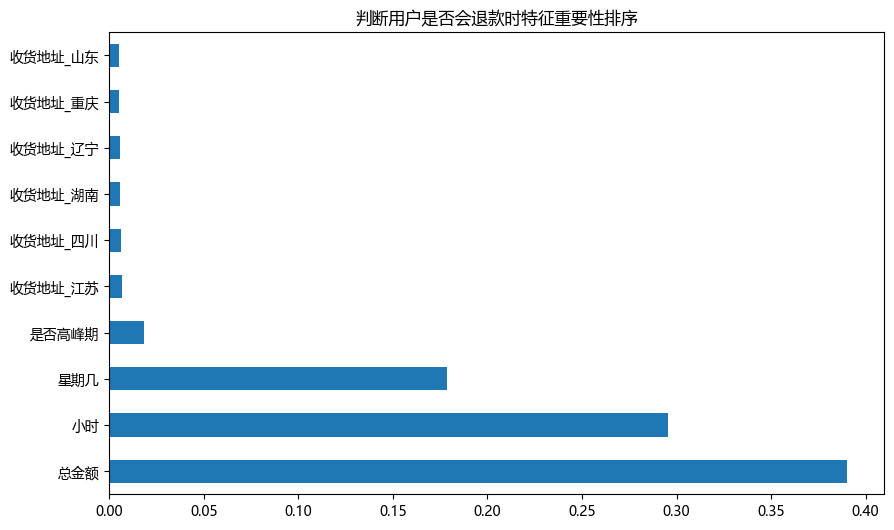


XGBoost模型表现：
              precision    recall  f1-score   support

           0       0.33      0.03      0.05      1187
           1       0.86      0.99      0.92      7216

    accuracy                           0.86      8403
   macro avg       0.60      0.51      0.48      8403
weighted avg       0.79      0.86      0.80      8403

准确率：0.86

高峰期与非高峰期对比：
高峰期转化率：86.37%
非高峰期转化率：85.90%

高金额订单(>75分位数)转化率：90.62%


In [210]:
# 数据预处理
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建特征
data['是否付款'] = data['订单付款时间'].notnull().astype(int)
data['小时'] = data['订单创建时间'].dt.hour
data['星期几'] = data['订单创建时间'].dt.dayofweek
data['是否高峰期'] = data['小时'].isin([10, 15, 21]).astype(int)

# 特征工程
features = pd.get_dummies(data[['小时', '星期几', '收货地址', '总金额', '是否高峰期']], columns=['收货地址'])
X = features
y = data['是否付款']

# 划分训练测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("随机森林模型表现：")
print(classification_report(y_test, y_pred))
print(f"准确率：{accuracy_score(y_test, y_pred):.2f}")

# 特征重要性
plt.figure(figsize=(10, 6))
pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('判断用户是否会退款时特征重要性排序')
plt.show()

# XGBoost模型
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\nXGBoost模型表现：")
print(classification_report(y_test, y_pred_xgb))
print(f"准确率：{accuracy_score(y_test, y_pred_xgb):.2f}")

# 高峰期影响因素分析
peak_hours = data[data['是否高峰期'] == 1]
non_peak_hours = data[data['是否高峰期'] == 0]

print("\n高峰期与非高峰期对比：")
print(f"高峰期转化率：{peak_hours['是否付款'].mean():.2%}")
print(f"非高峰期转化率：{non_peak_hours['是否付款'].mean():.2%}")

# 高金额订单分析
high_value = data[data['总金额'] > data['总金额'].quantile(0.75)]
print(f"\n高金额订单(>75分位数)转化率：{high_value['是否付款'].mean():.2%}")